In [1]:
#!/usr/bin/env python
# coding: utf-8

## ZnDTPとFM剤の酸化鉄表面吸着

import os, sys, csv, time, socket, glob, shutil #, re
from io import StringIO
import pickle
from itertools import combinations, product

# NOTE: Should I set "CUDA_VISIBLE_DEVICES" befor importing modules?

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase import Atoms

# from ase.md.langevin import Langevin
from ase.optimize import BFGS, FIRE
from ase import units

# from ase.md.npt import NPT
# from ase.md.verlet import VelocityVerlet
# from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.io import read, write
from ase.io.trajectory import Trajectory

# from ase.io.trajectory import Trajectory
from ase.build import surface, add_adsorbate, bulk
from ase.constraints import FixAtoms, StrainFilter, ExpCellFilter
from ase.visualize import view

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import optuna
from optuna.samplers import TPESampler
import nglview as nv
from nglview.datafiles import PDB, XTC

# from IPython.display import Image, display_png


### SMILES文字列から構造(元素と座標)を作成しase.Atomsを返す。

In [3]:
def smiles_to_atoms(smiles='CC', return_rwmol=False):
    rwmol = Chem.MolFromSmiles(smiles)
    rwmol = Chem.RWMol(rwmol)
    rwmol = AllChem.AddHs(rwmol)
    AllChem.EmbedMolecule(rwmol)
    with StringIO() as f:
        f.write(Chem.MolToPDBBlock(rwmol))
        f.seek(0)
        mol = read(f, format='proteindatabank')
    if return_rwmol:
        return mol, rwmol
    else:
        return mol

### 構造可視化の設定

In [4]:

def surview(atoms):
    v = nv.show_ase(atoms, gui=False)
    # v.control.zoom(-0.3)
    v.control.spin([1, 0, 0], 3.141 * 1.4)
    # v.control.spin ([0,1,0], 3.14)
    v.add_representation(
        repr_type="unitcell",
    )
    if len(atoms) > 400:
        v.add_representation(
            repr_type="spacefill",
        )
    v._remote_call("setSize", args=["250px", "400px"])
    v.background = "#161616"
    # add_xyz (v, atoms)
    return v

In [5]:



def add_xyz(view, atoms):
    view.shape.add("text", [0, 0, 0], [0.1, 0.5, 0.1], 4, "   0, 0, 0")
    x = int(sum(atoms.cell[:, 0]))
    y = int(sum(atoms.cell[:, 1]))
    z = int(sum(atoms.cell[:, 2]))
    view.shape.add(
        "text", [x, y, z], [0.1, 0.5, 0.1], 4, str(x) + "," + str(y) + "," + str(z)
    )


def add_no(view, atoms, v=[]):
    if v == []:
        v = list(range(len(atoms)))
        # v = list (range (10)) + list (range (len (atoms) - 20, len (atoms)))
    for i, atom in enumerate(atoms):
        if i in v:
            view.shape.add(
                "text", [atom.x, atom.y, atom.z], [0.1, 0.5, 0.1], 1, " " + str(i)
            )


def add_sym(view, atoms):
    for i, atom in enumerate(atoms):
        view.shape.add(
            "text", [atom.x, atom.y, atom.z], [0.5, 0.5, 0.5], 1, atom.symbol
        )


def add_dis(view, atoms, a1, a2):
    view.shape.add(
        "cylinder",
        [atoms[a1].x, atoms[a1].y, atoms[a1].z],
        [atoms[a2].x, atoms[a2].y, atoms[a2].z],
        [0.9, 0.1, 0.1],
        0.05,
    )
    x = 0.5 * (atoms[a1].x + atoms[a2].x)
    y = 0.5 * (atoms[a1].y + atoms[a2].y)
    z = 0.5 * (atoms[a1].z + atoms[a2].z)
    d = np.round(atoms.get_distance(a1, a2), 2)
    view.shape.add("text", [x, y, z], [0.9, 0.1, 0.1], 3, " " + str(d) + "A")



### 構造最適化

In [6]:


def myopt(
    atoms,
    fmax=0.05,
    steps=1000,
    maxstep=0.2,
    logfile=None,
    constraintatoms=[],
    calculator=None,
):
    sc = FixAtoms(indices=constraintatoms)
    atoms.set_constraint(sc)
    atoms.set_calculator(calculator)
    opt = BFGS(atoms, maxstep=maxstep, logfile=logfile)
    opt.run(fmax, steps=steps)
    return atoms



In [7]:

def SetCutoff(a):
    if a.get_pbc()[0] == True or a.get_pbc()[1] == True or a.get_pbc()[2] == True:
        print("Periodic system is not available")
        return 0.0
    else:
        pos = a.get_positions()
        rmin = 1.0e5
        for i in range(len(a)):
            for j in range(i + 1, len(a), 1):
                rx = pos[i, 0] - pos[j, 0]
                ry = pos[i, 1] - pos[j, 1]
                rz = pos[i, 2] - pos[j, 2]
                rr = np.sqrt(rx * rx + ry * ry + rz * rz)
                if rr < rmin:
                    rmin = rr
        rmin *= 0.99
        return rmin


def SetCutoffElem(a):
    if a.get_pbc()[0] == True or a.get_pbc()[1] == True or a.get_pbc()[2] == True:
        print("Periodic system is not available")
        return 0.0
    else:
        pos = a.get_positions()
        sym = a.get_chemical_symbols()
        rminH = 1.0e5
        rmin = 1.0e5
        for i in range(len(a)):
            for j in range(i + 1, len(a), 1):
                rx = pos[i, 0] - pos[j, 0]
                ry = pos[i, 1] - pos[j, 1]
                rz = pos[i, 2] - pos[j, 2]
                rr = np.sqrt(rx * rx + ry * ry + rz * rz)
                if sym[i] != "H" and sym[j] != "H":
                    if rr < rmin:
                        rmin = rr
                else:
                    if rr < rminH:
                        rminH = rr
        rmin *= 0.99
        rminH *= 0.99
        print("Cutoff for hydrogen: {:.2f} A".format(rminH))
        print("Cutoff for others:   {:.2f} A".format(rmin))
        return rmin, rminH



### Optunaに渡す関数の定義
TODO: classにする。

In [8]:

def init_objective(
    calculator,
    mol,
    slab,
    surface_elements,
    initx=0.0,
    inity=0.0,
    initz=0.0,
    rcut=1.2,
    rcutH=1.0,
    z_fix=6.0,
    fmax=0.1,
    steps=2000,
    maxstep=0.2,
    logfile=None,
    traj=None,
):
    if not hasattr(fmax, "__iter__"):
        fmax = [fmax]

    def _objective(trial):
        xmin = np.min(slab.get_positions()[:, 0])
        xmax = np.max(slab.get_positions()[:, 0])
        ymin = np.min(slab.get_positions()[:, 1])
        ymax = np.max(slab.get_positions()[:, 1])

        x_ang = trial.suggest_uniform("x_ang", 0.0, 360.0)
        y_ang = trial.suggest_uniform("y_ang", 0.0, 360.0)
        z_ang = trial.suggest_uniform("z_ang", 0.0, 360.0)
        x_pos = trial.suggest_uniform("x_pos", xmin, xmax)
        y_pos = trial.suggest_uniform("y_pos", ymin, ymax)
        z_hig = trial.suggest_uniform("z_hig", 2.0, 3.5)

        m = mol.copy()
        m.rotate(initx, "x")
        m.rotate(inity, "y")
        m.rotate(initz, "z")
        m.rotate(x_ang, "x")
        m.rotate(y_ang, "y")
        m.rotate(z_ang, "z")

        b = m.positions[:, 2].argmin()
        ads = slab.copy()
        ads = AddMol(
            ads, m, x_pos, y_pos, z_hig, b, 2.0, surface_elements=surface_elements
        )
        ads.wrap()
        err = CheckOverlapElem(ads, rcut, rcutH)
        if err == 0:
            c = [a.index for a in ads if a.z < z_fix]
            #            ads = myopt (ads, 0.1, 2000, 0.2, None, constraintatoms = c)
            # optimizeの収束条件を徐々に厳しくしつつ、保存や出力をする。
            for _fmax in fmax:
                ads = myopt(
                    ads,
                    fmax=_fmax,
                    steps=steps,
                    maxstep=maxstep,
                    logfile=logfile,
                    constraintatoms=c,
                    calculator=calculator,
                )
                # 後処理 (今は無し)
                
            if traj is not None:
                traj.write(ads)
            return ads.get_potential_energy()
        else:
            return 0.0

    return _objective, traj


In [9]:


def CheckOverlap(a, rcut):
    lx = a.get_cell_lengths_and_angles()[0]
    ly = a.get_cell_lengths_and_angles()[1]
    lz = a.get_cell_lengths_and_angles()[2]
    pos = a.get_positions()
    err = 0
    for i in range(len(a)):
        for j in range(i + 1, len(a), 1):
            rx = (pos[i, 0] - pos[j, 0]) / lx
            ry = (pos[i, 1] - pos[j, 1]) / ly
            rz = (pos[i, 2] - pos[j, 2]) / lz
            while rx < -0.5:
                rx += 1.0
            while rx > 0.5:
                rx -= 1.0
            while ry < -0.5:
                ry += 1.0
            while ry > 0.5:
                ry -= 1.0
            while rz < -0.5:
                rz += 1.0
            while rz > 0.5:
                rz -= 1.0
            rx *= lx
            ry *= ly
            rz *= lz
            rr = np.sqrt(rx * rx + ry * ry + rz * rz)
            if rr < rcut:
                err += 1
    return err


def CheckOverlapElem(a, rcut, rcutH):
    lx = a.get_cell_lengths_and_angles()[0]
    ly = a.get_cell_lengths_and_angles()[1]
    lz = a.get_cell_lengths_and_angles()[2]
    pos = a.get_positions()
    sym = a.get_chemical_symbols()
    err = 0
    for i in range(len(a)):
        for j in range(i + 1, len(a), 1):
            rx = (pos[i, 0] - pos[j, 0]) / lx
            ry = (pos[i, 1] - pos[j, 1]) / ly
            rz = (pos[i, 2] - pos[j, 2]) / lz
            while rx < -0.5:
                rx += 1.0
            while rx > 0.5:
                rx -= 1.0
            while ry < -0.5:
                ry += 1.0
            while ry > 0.5:
                ry -= 1.0
            while rz < -0.5:
                rz += 1.0
            while rz > 0.5:
                rz -= 1.0
            rx *= lx
            ry *= ly
            rz *= lz
            rr = np.sqrt(rx * rx + ry * ry + rz * rz)

            if sym[i] != "H" and sym[j] != "H":
                if rr < rcut:
                    err += 1
            else:
                if rr < rcutH:
                    err += 1
    return err



In [10]:

def AddMol(a, m, x, y, h, b, rcut=2.0, surface_elements=["Fe"]):

    if isinstance(surface_elements, str):
        surface_elements = [surface_elements]

    # POSITIONS AND CHEMICAL SYMBOLS
    pa = a.get_positions()
    sa = a.get_chemical_symbols()
    pm = m.get_positions()
    sm = m.get_chemical_symbols()
    # CELL
    lx = a.get_cell_lengths_and_angles()[0]
    ly = a.get_cell_lengths_and_angles()[1]
    lz = a.get_cell_lengths_and_angles()[2]
    # TRANSLATE MOLECULE POSITION
    pm -= pm[b]
    pm += [x, y, 0.0]
    # TOP SURFACE
    shift = 0.1
    z = np.max([atom.z for atom in a if atom.symbol in surface_elements]) - shift
    # CHECK OVERLAP
    rep = True
    while rep is True:
        z += shift
        err = 0
        for i in range(len(a)):
            for j in range(len(m)):
                rx = (pm[j, 0] - pa[i, 0]) / lx
                ry = (pm[j, 1] - pa[i, 1]) / ly
                rz = ((pm[j, 2] + z + h) - pa[i, 2]) / lz
                while rx < -0.5:
                    rx += 1.0
                while rx > 0.5:
                    rx -= 1.0
                while ry < -0.5:
                    ry += 1.0
                while ry > 0.5:
                    ry -= 1.0
                while rz < -0.5:
                    rz += 1.0
                while rz > 0.5:
                    rz -= 1.0
                rx *= lx
                ry *= ly
                rz *= lz
                rr = np.sqrt(rx * rx + ry * ry + rz * rz)
                if rr < rcut:
                    err += 1
        if err == 0:
            rep = False
    # TRANSLATE MOLECULE POSITION
    pm += [0.0, 0.0, z + h]
    # PLACE MOLECULE ON SLAB
    p = np.append(pa, pm, axis=0)
    s = np.append(sa, sm, axis=0)
    return Atoms(symbols=s, positions=p, cell=a.get_cell(), pbc=True)



### 分子とスラブの構造をファイルから読み込み、原子をソートする。

In [11]:

def read_structures(ads_structure_file, slab_structure_file, sort_atoms=True):
    
    if isinstance(ads_structure_file, Atoms):
        mol = ads_structure_file
    elif os.path.exists(ads_structure_file):
        mol = read(ads_structure_file)
    else:
        print(f"adsorbate structure {ads_structure_file} not found")
        print(f"in the current directory {os.getcwd()}")
        sys.exit()

    if isinstance(slab_structure_file, Atoms):
        slab = slab_structure_file
    elif os.path.exists(slab_structure_file):
        slab = read(slab_structure_file)
    else:
        print(f"slab structure {slab_structure_file} not found")
        print(f"in the current directory {os.getcwd()}")
        sys.exit()

    if sort_atoms:
        mol = mol[np.argsort(mol.get_chemical_symbols())]
        slab = slab[np.argsort(slab.get_chemical_symbols())]
    return mol, slab


### 構造最適化の関数myoptのラッパー関数。
分子、スラブ用に引数、前処理、後処理を加えたもの。

In [12]:
def optimize_molecule(mol,
        calculator=None,
        fmax=0.1,
        steps=1000,
        maxstep=0.02,
        outfile="mol_opt.json",
        logfile=None,
):

    mol = myopt(
        mol,
        fmax=fmax,
        steps=steps,
        maxstep=maxstep,
        logfile=logfile,
        calculator=calculator,
    )
    E_mol = mol.get_potential_energy()
    print("  E_mol = {:.4f} eV".format(E_mol))
    mol.write(outfile)
    
    return mol, E_mol

def optimize_slab(slab,
                  calculator=None,
                  z_fix=6.0,
                  fmax=0.1,
                  steps=1000000,
                  maxstep=0.02,
                  outfile='slab_opt.json',
                  logfile=None,
                  constraints=None,
                 ):

    if z_fix is not None:
        c = [a.index for a in slab if a.z < z_fix]
    else:
        c = constraints

    slab = myopt(
        slab,
        fmax=fmax,
        steps=steps,
        maxstep=maxstep,
        logfile=logfile,
        constraintatoms=c,
        calculator=calculator,
    )
    E_slab = slab.get_potential_energy()
    print("  E_slab = {:.4f} eV".format(E_slab))
    slab.write(outfile)
    return slab, E_slab




In [13]:
def check_initial_geometry(mol, 
                           slab,
                          initx=0.0,
                          inity=0.0,
                          initz=0.0,
                          ):

    tiny = sys.float_info.epsilon
    (lx, ly, lz) = slab.get_cell_lengths_and_angles()[0:3]

    m = mol.copy()
    m.rotate(initx, "x")
    m.rotate(inity, "y")
    m.rotate(initz, "z")
    b = m.positions[:, 2].argmin()
    ads = slab.copy()
    add_adsorbate(ads, m, 3.0, (0.5 * lx, 0.5 * ly), mol_index=b)
    d = ads.get_all_distances(mic=True)
    mask_nonzero = np.triu(d) > tiny
    dmin = np.min(d[mask_nonzero])
    print(f"Check the initial geometry: dmin = {dmin:.2f} ")
    return ads, dmin

### 吸着構造の探索

In [14]:

def find_ads_site(mol, 
                  slab, 
                  calculator, 
                  surface_elements=['Fe'], 
                  z_fix=6.0, 
                  # -->  分子の吸着位置の初期値
                  initx=0.0, 
                  inity=0.0, 
                  initz=0.0, 
                  # --> myoptの変数。構造最適化の収束条件
                  fmax=0.1, 
                  steps=1000, 
                  maxstep=0.02, 
                  # --> optunaの変数
                  n_trials=10,  # 探索の回数
                  n_jobs=1,     # 常に１
                  n_startup_sampling=10, # 探索最初のランダムサンプリングの数 
                  n_ei_candidates=24,    # EIの候補の数
                  seed_sampler=None,     # 乱数シード
                  multivariate=False,    # 変数が独立でない場合にTrue 
                  # --> 入出力
                  show_progress_bar=True,
                  trajfile='study.traj',
                  prefix='',
                  logfile=None,
                  group=False,
                  debug=False,
                 ):
    # --> Args for optuna study.
    print("# --> Exploring stable adsorption sites...")

    if trajfile is not None:
        traj = Trajectory(trajfile, "a")
    else:
        traj = None

    rcut, rcutH = SetCutoffElem(mol)
    
    # Optunaのデフォルトのsampler
    # 引数 multivariateを指定し、明示的にcreate_studyに渡す。
    sampler = TPESampler( 
        n_startup_trials=n_startup_sampling,
        n_ei_candidates=n_ei_candidates,
        seed=seed_sampler,
        multivariate=multivariate,
        group=group,
    )
    study = optuna.create_study(sampler=sampler)
    optuna.logging.disable_default_handler()
    #    study.optimize (objective, n_trials = 1000, n_jobs = 1, show_progress_bar = True)
    objective, traj = init_objective(
        calculator,
        mol,
        slab,
        surface_elements,
        initx,
        inity,
        initz,
        rcut,
        rcutH,
        z_fix,
        fmax=fmax,
        steps=steps,
        maxstep=maxstep,
        logfile=logfile,
        traj=traj,
    )
    study.optimize(
        objective,
        n_trials=n_trials,
        n_jobs=n_jobs,
        show_progress_bar=show_progress_bar,
    )
    # t1 = time.time()
    # print(f"  Elapsed time : {int(t1 - t0)} sec")
    print(
        f"  Elapsed time : {(study.trials[-1].datetime_complete - study.trials[0].datetime_start).seconds} sec"
    )
    if debug:
        try:
            with open(f"optuna_{study.study_name}.pickle", "wb") as f:
                pickle.dump(study, f)
        except Exception as p:
            study.trials_dataframe().to_csv(f"optuna_{study.study_name}.csv")
    if traj is not None:
        traj.close()

    # 最安定な吸着構造を取得
    x_ang = study.best_params["x_ang"]
    y_ang = study.best_params["y_ang"]
    z_ang = study.best_params["z_ang"]
    x_pos = study.best_params["x_pos"]
    y_pos = study.best_params["y_pos"]
    z_hig = study.best_params["z_hig"]

    m = mol.copy()
    m.rotate(initx, "x")
    m.rotate(inity, "y")
    m.rotate(initz, "z")
    m.rotate(x_ang, "x")
    m.rotate(y_ang, "y")
    m.rotate(z_ang, "z")
    b = m.positions[:, 2].argmin()
    ads = slab.copy()
    ads = AddMol(ads, m, x_pos, y_pos, z_hig, b, 2.0, surface_elements=surface_elements)
    ads.wrap()

    write(prefix + "ads_init.car", ads, format="dmol-car")

    return ads, study, traj


In [15]:
def save_results(study, E_ads, prefix=''):

    x_ang = study.best_params["x_ang"]
    y_ang = study.best_params["y_ang"]
    z_ang = study.best_params["z_ang"]
    x_pos = study.best_params["x_pos"]
    y_pos = study.best_params["y_pos"]
    z_hig = study.best_params["z_hig"]

    with open(prefix + "ads_optuna.csv", "w") as fp:
        w = csv.writer(fp)
        w.writerow(
            [
                "x_ang",
                "y_ang",
                "z_ang",
                "x_pos",
                "y_pos",
                "z_hig",
                "ads_eV",
                "ads_kJmol",
            ]
        )
        w.writerow(
            [
                x_ang,
                y_ang,
                z_ang,
                x_pos,
                y_pos,
                z_hig,
                E_ads,
                E_ads * units.mol / units.kJ,
            ]
        )

    ene = [each.value for each in study.trials]
    hyp = [each.params for each in study.trials]
    num = np.argsort(ene)
    with open(prefix + "hyperparam.csv", "w") as fp:
        w = csv.writer(fp)
        w.writerow(
            [
                "#trial",
                "x_ang",
                "y_ang",
                "z_ang",
                "x_pos",
                "y_pos",
                "z_hig",
                "energy_eV",
            ]
        )
        for i in num:
            w.writerow(
                [
                    i,
                    hyp[i]["x_ang"],
                    hyp[i]["y_ang"],
                    hyp[i]["z_ang"],
                    hyp[i]["x_pos"],
                    hyp[i]["y_pos"],
                    hyp[i]["z_hig"],
                    ene[i],
                ]
            )

In [16]:
def opt(
    pfp_ver="0102",
    gpu=1,
    prefix=None,
    # --> Args for building structure.
    structure_file="mol.car",
    z_fix=6.0,  # Fix slab atoms at z < z_fix.
    # --> Args for initial and final geometry optimizations.
    fmax=0.1,
    steps=2000,
    maxstep=0.02,
    basename='ads_opt',
    trajfile="opt.traj",
    logfile=None,
    debug=False,
):

    hostname = socket.gethostname()
    now = time.strftime("%Y%m%d %H:%M%S %Z")
    msg = f"{now} {hostname}"
    print(f"\nStarted at {msg}.")
    with open("running", "a") as f:
        print(msg, file=f)

    #    if debug and logfile is None:
    #        basename, expt = os.path.splitext(os.path.basename(__file__))
    #        logfile = f'{basename}.log'
    set_gpu(gpu)

    calculator, estimator, model_builder = setup_pfp_calculator(
        ver=pfp_ver,
        # ver = "0012"
        D_flag=True,
        U_flag=True,
    )

    if prefix is None:
        #        prefix, ext = os.path.splitext(os.path.basename(ads_structure_file))
        prefix = ""
    else:
        prefix = f"{prefix}_"

    # 分子の読み込み
    # 構造最適化済みの吸着構造の読み込み

    atoms = read(structure_file)
    # (lx, ly, lz) = atoms.get_cell_lengths_and_angles()[0:3]
    # df = pd.read_csv(reference_paramfile)

    print("# --> Optimizing the most stable geometry...")
    c = [a.index for a in atoms if a.z < z_fix]
    atoms = myopt(
        atoms,
        fmax=fmax,
        steps=steps,
        maxstep=maxstep,
        trajfile=trajfile,
        logfile=logfile,
        constraintatoms=c,
        calculator=calculator,
    )
    E_pot = atoms.get_potential_energy()
    print("  E_pot = {:.4f} eV".format(E_pot))

    write(prefix + f"{basename}.car", atoms, format="dmol-car")
    atoms.write(f"{basename}.json")

    now = time.strftime("%Y%m%d %H:%M%S %Z")
    msg = f"{now} {hostname}"
    print(f"\nFinished at {msg}.")
    with open("running", "a") as f:
        print(msg, file=f)
    os.rename("running", "finished")



In [17]:

def run(
    #    ads_structure_file="../kmeans/sarcosine_ole_opt.car",
    #    slab_structure_file="../ads_thick_optuna/NARROW_5x5/ZnDTP/ZnDTP_ads_opt.car",
    # --> Args for building structure.
    ads_structure_file="mol.car",
    slab_structure_file="slab.car",
    surface_elements=["Fe"],
    z_fix=6.0,  # Fix slab atoms at z < z_fix.
    initx=0.0,  # 分子の初期角度
    inity=0.0,  # 分子の初期角度
    initz=0.0,  # 分子の初期角度
    # --> Args for initial and final geometry optimizations.
    initial_opt_fmax=0.1,
    initial_opt_steps=1000,
    initial_opt_maxstep=0.02,
    final_opt_fmax=0.1,
    final_opt_steps=1000000,
    final_opt_maxstep=0.02,
    # --> Args for optuna sampler.
    multivariate=True,
    n_ei_candidates=24,
    n_startup_sampling=10,
    seed_sampler=None,
    # --> Args for optuna study.
    n_trials=10,
    n_jobs=1,
    fmax=0.1,
    steps=1000,
    maxstep=0.02,
    show_progress_bar=True,
    logfile=None,
    trajfile="study.traj",
    #    debug=False,
    # --> Calculator settings.
    # 	prefix = "sarcosine",
    pfp_ver="0102",
    gpu=1,
    prefix=None,
    group=False,
    debug=False,
):


    hostname = socket.gethostname()
    now = time.strftime("%Y%m%d %H:%M%S %Z")
    msg = f"{now} {hostname}"
    print(f"\nStarted at {msg}.")
    with open("running", "a") as f:
        print(msg, file=f)

    #    if debug and logfile is None:
    #        basename, expt = os.path.splitext(os.path.basename(__file__))
    #        logfile = f'{basename}.log'

    if prefix is None:
        #        prefix, ext = os.path.splitext(os.path.basename(ads_structure_file))
        prefix = ""
    else:
        prefix = f"{prefix}_"

    set_gpu(gpu)

    calculator, estimator, model_builder = setup_pfp_calculator(
        ver=pfp_ver,
        # ver = "0012"
        D_flag=True,
        U_flag=True,
    )


    # 分子の読み込み
    # 構造最適化済みの吸着構造の読み込み
    mol, slab = read_structures(
        ads_structure_file, slab_structure_file, sort_atoms=True
    )

    # 分子と吸着構造の構造最適化
    print("# --> Optimizing the molecule and slab geometries...")
    sys.stdout.flush()

    mol, E_mol = optimize_molecule(
        mol,
        fmax=initial_opt_fmax,
        steps=initial_opt_steps,
        maxstep=initial_opt_maxstep,
        logfile=logfile,
        calculator=calculator,
        outfile='mol_opt.json',
    )

    v = surview(mol)
    slab, E_slab = optimize_slab(slab,
                                 z_fix=z_fix,
                                 fmax=initial_opt_fmax,
                                 steps=1e10,
                                 maxstep=initial_opt_maxstep,
                                 logfile=logfile,
                                 calculator=calculator,
                                 outfile='slab_opt.json'
    )

    v = surview(slab)

    ads, dmin = check_initial_geometry(mol, slab, initx=initx, inity=inity, initz=initz)
    v = surview(ads)

    ads, study, traj = find_ads_site(mol, 
                  slab, 
                  z_fix=z_fix, 
                  surface_elements=surface_elements, 
                  calculator=calculator, 
                  initx=initx, 
                  inity=inity, 
                  initz=initz, 
                  n_trials=n_trials,
                  n_jobs=n_jobs,
                  show_progress_bar=show_progress_bar,
                  logfile=None,
                  trajfile="study.traj",
                  fmax=fmax, 
                  steps=steps, 
                  maxstep=maxstep, 
                  n_startup_sampling=n_startup_sampling, 
                  n_ei_candidates=n_ei_candidates, 
                  seed_sampler=seed_sampler, 
                  multivariate=multivariate, 
                  group=group)

    print("# --> Optimizing the most stable geometry...")

    ads, E_mol_slab = optimize_slab(ads,
                  calculator=calculator,
                  z_fix=z_fix,
                  fmax=final_opt_fmax,
                  steps=final_opt_steps,
                  maxstep=final_opt_maxstep,
                  logfile=logfile,
                  outfile='slab_opt.json',
                 )
    print("  E_mol_slab = {:.4f} eV".format(E_mol_slab))

    write(prefix + "ads_opt.car", ads, format="dmol-car")
    ads.write("ads_opt.json")

    E_ads = E_mol_slab - (E_mol + E_slab)
    print("# --> Results ")
    print("Adsorption energy: {:.4f} eV".format(E_ads))
    print("Adsorption energy: {:.4f} kJ/mol".format(E_ads * units.mol / units.kJ))
    v = surview(ads)
   
    save_results(study, E_ads, prefix=prefix)

    now = time.strftime("%Y%m%d %H:%M%S %Z")
    msg = f"{now} {hostname}"
    print(f"\nFinished at {msg}.")
    with open("running", "a") as f:
        print(msg, file=f)
    os.rename("running", "finished")
    return ads, E_ads, study


## 吸着させる分子構造の生成
 SMILES文字列 + RDKit を使って吸着させる分子の構造データ(元素と座標)を生成する。
 ここでは両端 (SMILESのXとY) それぞれ2種類の官能基の組み合わせ、合計4分子を作成する。

In [18]:
def test():
    mols, rwmols = test_gen_mols()
    slab, z_fix = test_gen_slab()
    optimized_structures, adsorption_energies, studies = test_opt(mols, slab, z_fix)
    test_view(adsorption_energies, optimized_structures)
    test_analyze()
    clean_files()

In [19]:

def test_gen_mols():
    smiles_template = 'XCCCC=CCCCY'
    end_fragments_X = ['O', 'c1cc(ccc1)C']
    end_fragments_Y = ['(=O)O', 'N']

    xy = list(product(end_fragments_X, end_fragments_Y))
    smileses = [smiles_template.replace('X', x).replace('Y', y) for x, y in xy]
    print(list(xy))
    print(smileses)

    mols = [smiles_to_atoms(_, return_rwmol=True) for _ in smileses]
    rwmols = [_[1] for _ in mols]
    mols = [_[0] for _ in mols]

    for (_mol, _rwmol) in zip(mols, rwmols):
        display(surview(_mol))
        display(_rwmol)
    return mols, rwmols

## 分子を吸着させる表面スラブ模型の作成
ase.build.bulkをつかってCu(111)表面 6x6x1 4L スラブ構造を作成

In [20]:
def test_gen_slab():
    bulk_Cu = bulk('Cu', 'fcc')
    repeat = [6, 6, 1]
    num_layers = 4
    vacuum=20.0
    direction = (1, 1, 1)
    slab = surface(bulk_Cu, direction, num_layers, vacuum=vacuum, periodic=True)
    slab = slab * repeat

    # 最下層を固定するための座標z_fixを取得しておく。
    # 表面吸着構造の最適化では、z < z_fix の原子をすべて固定する
    z = np.unique(slab.positions[:, 2])
    print(z)
    z_fix = np.min(z) + 0.5 # 大小判定のために、少し余裕(0.5A)をもたせておく。 
    print(z_fix)
    display(surview(slab))
    return slab, z_fix

In [21]:
### print関数の出力先をファイルに置き換える
# 以下を実行すると、print関数の結果がノートブックに出力されず、ファイルに保存される。
# --> 出力がjuypterのセルにもどらなかった。loggingをつかうべき。
#print(sys.__stdout__)
#print(sys.stderr)
#print(sys.stderr)

#stdout = open('stdout', 'a')
#stderr = open('stderr', 'a')
#(sys.stdout, stdout) = stdout, sys.stdout
#(sys.stderr, stderr) = stderr, sys.stderr

## 吸着構造の最適化
4つの分子それぞれについて吸着構造を探索し、結果をファイルに保存する。
* mol_opt.json　吸着分子の構造 (ASE json)
* slab_opt.json　スラブの構造 (ASE json)
* ads_init.car　optunaの探索後の構造 (car)
* ads_opt.car, ads_opt.json   ads_init.carを最適化した構造 (car, ASE json)
* ads_optuna.csv  optunaの最適解と最適値
* hyperparam.csv  optunaの途中経過
* study.traj　　　optunaで探索された全ての構造(ASE Trajectory)

In [27]:
def test_opt(mols, slab, z_fix):
    save_file_formats = ['.car', '.csv', '.json', 'traj']
    exist_ok = True  # ファイルがすでに存在する場合に上書きする。
    n_trials=15
    n_startup_sampling=10
    surface_elements = ['Cu']

    optimized_structures = []
    adsorption_energies = []
    studies = []
    for i, mol in enumerate(mols):
        destdir = f'{i}'
        os.makedirs(destdir, exist_ok=exist_ok)
        
        _ads, _e_ads, _study = run(mol, 
                slab, 
                surface_elements,
                multivariate=True,  # 変数が独立でない場合(目視でわかる解をなかなか見つけてくれない場合)にTrueにする。
                z_fix=z_fix, 
                n_startup_sampling=n_startup_sampling,  # ランダムな初期値の数。大きいほど局所解に落ちにくい。
                n_trials=n_trials   # optunaの探索回数。大きいほどより極値に近づく。
                                )
        optimized_structures.append(_ads)
        adsorption_energies.append(_e_ads)
        studies.append(_study)
        
        _files = np.concatenate([glob.glob(f'*{_}') for _ in save_file_formats]).tolist()
        for _file in _files:
            if exist_ok:
                shutil.move(_file, os.path.join(destdir, os.path.basename(_file)))
            else:
                shutil.move(_file, destdir)
    return optimized_structures, adsorption_energies, studies

In [28]:
## print関数の出力先を元に戻す
#sys.stdout, stdout = stdout, sys.stdout
#sys.stderr, stderr = stderr, sys.stderr
#stdout.close()
#stderr.close()
# 正しく設定できていれば、以下print文の結果が（ファイルではなく）セルに出力される。
# --> jupyter notebookでは動かなかった。
#print(sys.stdout)
#print(sys.stderr)

## optunaの探索結果を確認する

In [29]:
def test_view(adsorption_energies, optimized_structures):
    print(adsorption_energies)
    for _ads in optimized_structures:
        display(surview(_ads))


In [30]:
def test_analyze(
    srcdir="1",
    trajfile="study.traj",
    adsfile="ads_opt.json",
    paramfile="hyperparam.csv",
    resultfile="ads_optuna.csv",
):

    # --> trajectoryファイルからデータを取得
    traj = read(os.path.join(srcdir, trajfile), index=":")
    ene_trials = np.array([_atoms.get_potential_energy() for _atoms in traj])
    idx_min = ene_trials.argmin()

    print(idx_min)
    # print(ene_trials)
    # --> 最適化後のASE Atomsを取得
    ads = read(os.path.join(srcdir, adsfile))

    # --> csvファイルからデータを取得
    print("Results of optuna:")
    params = pd.read_csv(os.path.join(srcdir, paramfile))
    # 計算に失敗したデータを除く
    params = params[params.energy_eV < 0].sort_values("#trial").reset_index(drop=True)
    idx_min_param = params["energy_eV"].idxmin()
    display(params.loc[[idx_min_param]])
    # display(params)
    print("Adsorption energies of optimized geometries:")
    res = pd.read_csv(os.path.join(srcdir, resultfile))
    display(res)

    plt.plot(ene_trials)
    params.plot(y="energy_eV")

    display(surview(ads))
    display(surview(traj[idx_min]))
    display(view(traj, viewer="ngl"))


In [ ]:
def clean_files():
    removefiles = ['mol_opt.json', 'slab_opt.json', 'ads_init.car', 'study.traj', 'finished', 'running']
    for _file in removefiles:
        if os.path.exists(_file):
            os.remove(_file)

[('O', '(=O)O'), ('O', 'N'), ('c1cc(ccc1)C', '(=O)O'), ('c1cc(ccc1)C', 'N')]
['OCCCC=CCCC(=O)O', 'OCCCC=CCCCN', 'c1cc(ccc1)CCCCC=CCCC(=O)O', 'c1cc(ccc1)CCCCC=CCCCN']


NGLWidget(background='#161616')

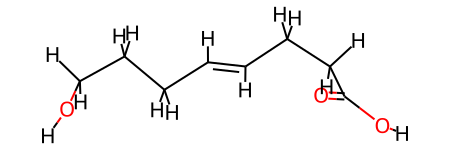

NGLWidget(background='#161616')

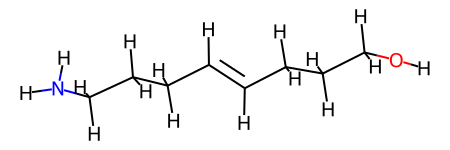

NGLWidget(background='#161616')

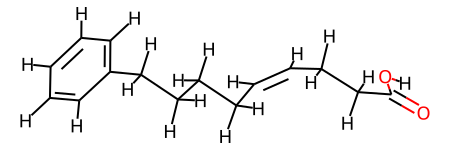

NGLWidget(background='#161616')

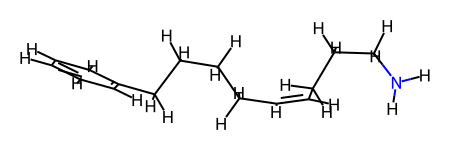

[20.         22.08423447 24.16846894 26.25270342]
20.5


NGLWidget(background='#161616')


Started at 20220525 16:1840 JST pfn22g.
GPU: 1
No module named 'pfp_api_client'
<VER: 0102>   <DFT-U: True>   <D3: True>
Loading PFP v1.2.2.
EstimatorCalcMode.CRYSTAL
D3 correction: <torch_dftd.torch_dftd3_calculator.TorchDFTD3Calculator object at 0x7ff1b1767c90>
# --> Optimizing the molecule and slab geometries...
  E_mol = -144.4556 eV


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)
/opt/anaconda3/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:266: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2022-05-25 16:19:06,359] A new study created in memory with name: no-name-4cc7bc9d-e8d3-4df1-bac8-577028321ffa


  E_slab = -305.0122 eV
Check the initial geometry: dmin = 0.97 
# --> Exploring stable adsorption sites...
Cutoff for hydrogen: 0.96 A
Cutoff for others:   1.21 A


/opt/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:12,525] Trial 0 finished with value: -450.0986821502086 and parameters: {'x_ang': 248.59432274788819, 'y_ang': 49.07294300589827, 'z_ang': 112.57619548496211, 'x_pos': 12.151410231587683, 'y_pos': 5.738220832821559, 'z_hig': 3.2465305060798224}. Best is trial 0 with value: -450.0986821502086.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:19,463] Trial 1 finished with value: -450.3215048911894 and parameters: {'x_ang': 105.38524906513211, 'y_ang': 212.98801580052913, 'z_ang': 151.11124109654068, 'x_pos': 9.424688079164994, 'y_pos': 10.40363877043945, 'z_hig': 2.2593229309490828}. Best is trial 1 with value: -450.3215048911894.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:20,334] Trial 2 finished with value: -450.0883648731027 and parameters: {'x_ang': 53.3327125781681, 'y_ang': 196.84142552720473, 'z_ang': 206.0834735323003, 'x_pos': 10.810247984227944, 'y_pos': 12.393325946379038, 'z_hig': 2.6803709059239704}. Best is trial 1 with value: -450.3215048911894.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:20,807] Trial 3 finished with value: -449.9061505350883 and parameters: {'x_ang': 170.34218895404967, 'y_ang': 346.552599755521, 'z_ang': 272.6380683399928, 'x_pos': 12.32716985729557, 'y_pos': 11.100360954172812, 'z_hig': 3.124905095199095}. Best is trial 1 with value: -450.3215048911894.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:28,086] Trial 4 finished with value: -450.48152732584686 and parameters: {'x_ang': 23.948891785164168, 'y_ang': 161.48498421295173, 'z_ang': 57.04967779568122, 'x_pos': 13.756869987280762, 'y_pos': 3.8160309973371493, 'z_hig': 2.4372439420979175}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:34,939] Trial 5 finished with value: -450.0846728744799 and parameters: {'x_ang': 166.47239639135304, 'y_ang': 45.39475239624437, 'z_ang': 161.83347168217344, 'x_pos': 16.234312070061335, 'y_pos': 8.23059791329425, 'z_hig': 2.679325391594693}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:41,781] Trial 6 finished with value: -450.21600350878583 and parameters: {'x_ang': 274.5633568244637, 'y_ang': 281.072102031448, 'z_ang': 265.08918623413257, 'x_pos': 2.510591695139854, 'y_pos': 12.975564973543513, 'z_hig': 2.1228461357214496}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:48,279] Trial 7 finished with value: -450.42230692990825 and parameters: {'x_ang': 272.85814569164035, 'y_ang': 12.985763871625169, 'z_ang': 242.62946336505928, 'x_pos': 2.755173904443832, 'y_pos': 0.3871160502085398, 'z_hig': 2.1621869522769535}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:19:57,307] Trial 8 finished with value: -450.1417905593896 and parameters: {'x_ang': 261.39026721894214, 'y_ang': 89.69217026024216, 'z_ang': 100.08035434482377, 'x_pos': 6.158570196566503, 'y_pos': 2.546741907388198, 'z_hig': 2.1179394197528176}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:03,453] Trial 9 finished with value: -450.04439059732334 and parameters: {'x_ang': 195.0688394202577, 'y_ang': 269.0035741588251, 'z_ang': 307.52721309898067, 'x_pos': 5.254281403013018, 'y_pos': 3.337269739386883, 'z_hig': 3.0798037436056074}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:04,325] Trial 10 finished with value: -450.02870263342345 and parameters: {'x_ang': 104.62736278393548, 'y_ang': 207.4485551262817, 'z_ang': 125.47767645841205, 'x_pos': 13.401236815665358, 'y_pos': 2.043008399785947, 'z_hig': 2.708602262514502}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:12,761] Trial 11 finished with value: -450.144927394249 and parameters: {'x_ang': 358.2912863430863, 'y_ang': 92.27126183631005, 'z_ang': 266.569454946443, 'x_pos': 3.3514212611289844, 'y_pos': 1.9671634693591271, 'z_hig': 2.126182278486643}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:19,617] Trial 12 finished with value: -450.12428931347876 and parameters: {'x_ang': 180.74027603164788, 'y_ang': 48.578450889028574, 'z_ang': 322.88465053164384, 'x_pos': 3.115544710499138, 'y_pos': 4.473128422209385, 'z_hig': 2.5646015878259565}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:26,025] Trial 13 finished with value: -450.1390680290822 and parameters: {'x_ang': 25.75629267837947, 'y_ang': 107.07510851748577, 'z_ang': 170.55811189982728, 'x_pos': 13.027080551347009, 'y_pos': 4.89179423413427, 'z_hig': 2.3838846855612177}. Best is trial 4 with value: -450.48152732584686.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:32,924] Trial 14 finished with value: -450.2144913032612 and parameters: {'x_ang': 12.475462844587886, 'y_ang': 314.04200708009785, 'z_ang': 57.47044416375207, 'x_pos': 9.834065258256778, 'y_pos': 6.156055569078132, 'z_hig': 2.3702238127334554}. Best is trial 4 with value: -450.48152732584686.
  Elapsed time : 86 sec
# --> Optimizing the most stable geometry...
  E_slab = -450.4815 eV
  E_mol_slab = -450.4815 eV
# --> Results 
Adsorption energy: -1.0138 eV
Adsorption energy: -97.8156 kJ/mol

Finished at 20220525 16:2040 JST pfn22g.

Started at 20220525 16:2040 JST pfn22g.
GPU: 1
No module named 'pfp_api_client'
<VER: 0102>   <DFT-U: True>   <D3: True>
Loading PFP v1.2.2.
EstimatorCalcMode.CRYSTAL
D3 correction: <torch_dftd.torch_dftd3_calculator.TorchDFTD3Calculator object at 0x7fef7878af10>
# --> Optimizing the molecule and slab geometries...
  E_mol = -149.9943 eV


/opt/anaconda3/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:266: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2022-05-25 16:20:45,077] A new study created in memory with name: no-name-400abc0b-ac71-4d3f-b971-bf673ff0c57a


  E_slab = -305.0122 eV
Check the initial geometry: dmin = 0.97 
# --> Exploring stable adsorption sites...
Cutoff for hydrogen: 0.96 A
Cutoff for others:   1.32 A


/opt/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:52,141] Trial 0 finished with value: -455.7817656911617 and parameters: {'x_ang': 259.1285414022814, 'y_ang': 213.1447683264701, 'z_ang': 205.70820322749626, 'x_pos': 19.95442695235957, 'y_pos': 0.5057698884286148, 'z_hig': 2.223120239130021}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:58,239] Trial 1 finished with value: -455.64521985922755 and parameters: {'x_ang': 212.13503577331912, 'y_ang': 311.4975021203654, 'z_ang': 105.25709667376674, 'x_pos': 2.75621475646635, 'y_pos': 6.9883313039134185, 'z_hig': 3.0671402251961686}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:20:59,158] Trial 2 finished with value: -455.2779656786392 and parameters: {'x_ang': 260.66683006018417, 'y_ang': 253.64619827742882, 'z_ang': 298.4129203513997, 'x_pos': 11.762045789673616, 'y_pos': 1.5568946497394205, 'z_hig': 2.7900397297345787}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:06,390] Trial 3 finished with value: -455.7079212285628 and parameters: {'x_ang': 204.59796218950984, 'y_ang': 122.64451157930803, 'z_ang': 193.65367648714422, 'x_pos': 10.620448410146226, 'y_pos': 0.10195569747172913, 'z_hig': 2.336463065491543}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:13,790] Trial 4 finished with value: -455.76812848430615 and parameters: {'x_ang': 345.38950512839784, 'y_ang': 148.84777087437672, 'z_ang': 296.6765473822246, 'x_pos': 19.864837599864288, 'y_pos': 10.760500204742684, 'z_hig': 2.50331251790594}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:21,287] Trial 5 finished with value: -455.6975653831317 and parameters: {'x_ang': 226.93204353895382, 'y_ang': 327.24770479993845, 'z_ang': 287.18051309618755, 'x_pos': 19.322856805923685, 'y_pos': 8.962001233220503, 'z_hig': 3.1377705557906763}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:28,717] Trial 6 finished with value: -455.64990500988205 and parameters: {'x_ang': 356.50365320003596, 'y_ang': 250.40228291678972, 'z_ang': 147.75345795328104, 'x_pos': 18.51948984429129, 'y_pos': 3.6239321139693668, 'z_hig': 2.4240066510387765}. Best is trial 0 with value: -455.7817656911617.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:40,901] Trial 7 finished with value: -456.2240541392387 and parameters: {'x_ang': 20.733756914021676, 'y_ang': 342.0355011925737, 'z_ang': 298.08516633994645, 'x_pos': 1.5552108688200725, 'y_pos': 6.266097479052161, 'z_hig': 2.0877409162119416}. Best is trial 7 with value: -456.2240541392387.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:47,494] Trial 8 finished with value: -455.67361967994816 and parameters: {'x_ang': 202.70617316682768, 'y_ang': 31.305546122684802, 'z_ang': 318.0267443956617, 'x_pos': 0.39177742838548224, 'y_pos': 12.256277807451673, 'z_hig': 2.900323645789814}. Best is trial 7 with value: -456.2240541392387.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:21:54,617] Trial 9 finished with value: -455.8507905671009 and parameters: {'x_ang': 81.73569686073085, 'y_ang': 222.39513307783068, 'z_ang': 79.37124887065855, 'x_pos': 9.913293233745476, 'y_pos': 10.959456789623754, 'z_hig': 2.227527524262074}. Best is trial 7 with value: -456.2240541392387.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:22:01,849] Trial 10 finished with value: -455.67239123280314 and parameters: {'x_ang': 50.69751955535584, 'y_ang': 301.2200308636247, 'z_ang': 275.4185682223726, 'x_pos': 2.091066555371171, 'y_pos': 5.714776916170019, 'z_hig': 2.055679391490653}. Best is trial 7 with value: -456.2240541392387.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:22:09,194] Trial 11 finished with value: -456.1922225788636 and parameters: {'x_ang': 53.58344214175882, 'y_ang': 201.42991299351417, 'z_ang': 150.71265494803322, 'x_pos': 11.011939805920168, 'y_pos': 12.091368588546446, 'z_hig': 2.3689895784459134}. Best is trial 7 with value: -456.2240541392387.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:22:35,086] Trial 12 finished with value: -456.4011811911315 and parameters: {'x_ang': 11.885759031920855, 'y_ang': 344.90776177380985, 'z_ang': 313.77851371411236, 'x_pos': 9.170216755028015, 'y_pos': 11.657544875830656, 'z_hig': 2.498032037071372}. Best is trial 12 with value: -456.4011811911315.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:22:35,951] Trial 13 finished with value: -455.3907646342245 and parameters: {'x_ang': 50.32009036691606, 'y_ang': 325.51295071616977, 'z_ang': 301.7203035922549, 'x_pos': 9.09540436647959, 'y_pos': 12.42604695522564, 'z_hig': 2.774141116209611}. Best is trial 12 with value: -456.4011811911315.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:22:36,821] Trial 14 finished with value: -455.30386503252265 and parameters: {'x_ang': 2.36560070252035, 'y_ang': 304.2443681417981, 'z_ang': 254.8733035594973, 'x_pos': 0.9547852689838677, 'y_pos': 1.5531077446004122, 'z_hig': 2.830048493416506}. Best is trial 12 with value: -456.4011811911315.
  Elapsed time : 111 sec
# --> Optimizing the most stable geometry...
  E_slab = -456.4012 eV
  E_mol_slab = -456.4012 eV
# --> Results 
Adsorption energy: -1.3947 eV
Adsorption energy: -134.5669 kJ/mol

Finished at 20220525 16:2303 JST pfn22g.

Started at 20220525 16:2303 JST pfn22g.
GPU: 1
No module named 'pfp_api_client'
<VER: 0102>   <DFT-U: True>   <D3: True>
Loading PFP v1.2.2.
EstimatorCalcMode.CRYSTAL
D3 correction: <torch_dftd.torch_dftd3_calculator.TorchDFTD3Calculator object at 0x7fef786d2c10>
# --> Optimizing the molecule and slab geometries...
  E_mol = -223.5189 eV


/opt/anaconda3/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:266: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2022-05-25 16:23:08,532] A new study created in memory with name: no-name-237ddca1-6122-4642-a151-f3fb902a6801


  E_slab = -305.0122 eV
Check the initial geometry: dmin = 0.98 
# --> Exploring stable adsorption sites...
Cutoff for hydrogen: 0.97 A
Cutoff for others:   1.21 A


/opt/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:15,644] Trial 0 finished with value: -529.3166064954817 and parameters: {'x_ang': 143.88045666787545, 'y_ang': 260.96567599645675, 'z_ang': 348.6506106121903, 'x_pos': 9.457332523168464, 'y_pos': 4.358519197240986, 'z_hig': 2.1943345974910904}. Best is trial 0 with value: -529.3166064954817.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:23,747] Trial 1 finished with value: -529.3448223601382 and parameters: {'x_ang': 63.098078840903746, 'y_ang': 97.89230752319669, 'z_ang': 117.73907044832117, 'x_pos': 4.362633177882049, 'y_pos': 6.823474176803284, 'z_hig': 2.3481947833246637}. Best is trial 1 with value: -529.3448223601382.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:34,360] Trial 2 finished with value: -529.4151490390489 and parameters: {'x_ang': 126.59222375148097, 'y_ang': 56.524106900004845, 'z_ang': 304.6128841978544, 'x_pos': 13.770680934483151, 'y_pos': 2.5048636355906293, 'z_hig': 2.1481261584801947}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:35,300] Trial 3 finished with value: -529.026923847612 and parameters: {'x_ang': 226.39792238797045, 'y_ang': 207.86996660321654, 'z_ang': 233.60104181972048, 'x_pos': 10.923257953123922, 'y_pos': 8.86556706017969, 'z_hig': 2.824030909862256}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:36,236] Trial 4 finished with value: -528.9873495579276 and parameters: {'x_ang': 0.9316434423757247, 'y_ang': 278.3165313017946, 'z_ang': 23.24943911851594, 'x_pos': 7.7352543859261385, 'y_pos': 5.398142026814128, 'z_hig': 2.8080304738005233}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:43,243] Trial 5 finished with value: -529.2016317969321 and parameters: {'x_ang': 337.8777456929153, 'y_ang': 51.610630223474345, 'z_ang': 27.15335036050204, 'x_pos': 21.479552762881088, 'y_pos': 9.311585203059268, 'z_hig': 3.0094317697564805}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:44,298] Trial 6 finished with value: -528.858504264851 and parameters: {'x_ang': 118.91603160685412, 'y_ang': 299.167583280388, 'z_ang': 323.99085119000654, 'x_pos': 12.011032955050975, 'y_pos': 11.139132790831527, 'z_hig': 3.1471561588947954}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:50,811] Trial 7 finished with value: -529.2021367384905 and parameters: {'x_ang': 183.8074372427638, 'y_ang': 344.94932554592776, 'z_ang': 100.89523034008155, 'x_pos': 17.341975089829823, 'y_pos': 10.712910882161005, 'z_hig': 3.156567869784711}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:57,984] Trial 8 finished with value: -529.1094515957867 and parameters: {'x_ang': 222.9241041295136, 'y_ang': 64.52544438108914, 'z_ang': 39.9249326234091, 'x_pos': 3.1842419730340836, 'y_pos': 10.738464479873397, 'z_hig': 3.141982759493748}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:23:58,937] Trial 9 finished with value: -529.0633767828799 and parameters: {'x_ang': 95.24259920151401, 'y_ang': 341.30735984924945, 'z_ang': 90.25693504520957, 'x_pos': 9.20297582603945, 'y_pos': 4.240776487653777, 'z_hig': 2.9807341496646327}. Best is trial 2 with value: -529.4151490390489.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:09,231] Trial 10 finished with value: -529.6114228940311 and parameters: {'x_ang': 114.52011737660338, 'y_ang': 139.53367337670878, 'z_ang': 346.39414785674217, 'x_pos': 21.305915946408298, 'y_pos': 3.220004109834574, 'z_hig': 2.2239505783108333}. Best is trial 10 with value: -529.6114228940311.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:16,313] Trial 11 finished with value: -529.7143704843681 and parameters: {'x_ang': 110.33272968366212, 'y_ang': 155.8668212466948, 'z_ang': 261.00958248264004, 'x_pos': 21.62317976332909, 'y_pos': 3.716152254213481, 'z_hig': 2.09415481327068}. Best is trial 11 with value: -529.7143704843681.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:23,954] Trial 12 finished with value: -529.7708074035125 and parameters: {'x_ang': 45.13648823194593, 'y_ang': 187.13627739629982, 'z_ang': 296.35261412561727, 'x_pos': 19.798078842026463, 'y_pos': 4.282383125161375, 'z_hig': 2.1817238891152355}. Best is trial 12 with value: -529.7708074035125.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:32,772] Trial 13 finished with value: -529.4388988193523 and parameters: {'x_ang': 81.98732066088083, 'y_ang': 130.56191786457404, 'z_ang': 171.09664318846774, 'x_pos': 17.8384739434367, 'y_pos': 9.385223575264042, 'z_hig': 2.1827167043389424}. Best is trial 12 with value: -529.7708074035125.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:39,260] Trial 14 finished with value: -529.4274446992523 and parameters: {'x_ang': 139.4181466177692, 'y_ang': 166.0369892197535, 'z_ang': 158.32669070856736, 'x_pos': 20.16452927335068, 'y_pos': 1.2268990035982652, 'z_hig': 2.640261528155345}. Best is trial 12 with value: -529.7708074035125.
  Elapsed time : 90 sec
# --> Optimizing the most stable geometry...
  E_slab = -529.7708 eV
  E_mol_slab = -529.7708 eV
# --> Results 
Adsorption energy: -1.2397 eV
Adsorption energy: -119.6149 kJ/mol

Finished at 20220525 16:2446 JST pfn22g.

Started at 20220525 16:2446 JST pfn22g.
GPU: 1
No module named 'pfp_api_client'
<VER: 0102>   <DFT-U: True>   <D3: True>
Loading PFP v1.2.2.
EstimatorCalcMode.CRYSTAL
D3 correction: <torch_dftd.torch_dftd3_calculator.TorchDFTD3Calculator object at 0x7fef7862a910>
# --> Optimizing the molecule and slab geometries...
  E_mol = -229.1216 eV


/opt/anaconda3/lib/python3.7/site-packages/optuna/samplers/_tpe/sampler.py:266: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2022-05-25 16:24:51,645] A new study created in memory with name: no-name-d24c5b6b-ac4e-44ef-bcb9-b5a4e6b92a58


  E_slab = -305.0122 eV
Check the initial geometry: dmin = 1.02 
# --> Exploring stable adsorption sites...
Cutoff for hydrogen: 1.01 A
Cutoff for others:   1.33 A


/opt/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:52,622] Trial 0 finished with value: -534.4218257525474 and parameters: {'x_ang': 284.71405700968546, 'y_ang': 128.33772372162028, 'z_ang': 215.8163519486674, 'x_pos': 18.13535709526637, 'y_pos': 10.360300695350242, 'z_hig': 3.380092534778501}. Best is trial 0 with value: -534.4218257525474.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:24:59,198] Trial 1 finished with value: -534.8439300405781 and parameters: {'x_ang': 359.2129319283937, 'y_ang': 269.2616060239058, 'z_ang': 31.704638716085288, 'x_pos': 17.22021349301049, 'y_pos': 7.1652041099074415, 'z_hig': 2.467723055850478}. Best is trial 1 with value: -534.8439300405781.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:05,897] Trial 2 finished with value: -534.7909130151043 and parameters: {'x_ang': 160.20620555866964, 'y_ang': 62.16028105098963, 'z_ang': 313.8641483939267, 'x_pos': 5.566135070654008, 'y_pos': 3.636330407113847, 'z_hig': 2.754609574825202}. Best is trial 1 with value: -534.8439300405781.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:06,921] Trial 3 finished with value: -534.4542524743384 and parameters: {'x_ang': 7.685179887245206, 'y_ang': 260.065491544274, 'z_ang': 318.4618045786923, 'x_pos': 8.08526528928578, 'y_pos': 12.735493690068674, 'z_hig': 3.2684106476998194}. Best is trial 1 with value: -534.8439300405781.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:07,873] Trial 4 finished with value: -534.4000967220178 and parameters: {'x_ang': 213.17604342919338, 'y_ang': 61.49978272127553, 'z_ang': 294.4172819619255, 'x_pos': 8.33647467816427, 'y_pos': 2.3241325974170524, 'z_hig': 3.454832255000219}. Best is trial 1 with value: -534.8439300405781.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:18,696] Trial 5 finished with value: -535.2459720312615 and parameters: {'x_ang': 8.67889303303198, 'y_ang': 167.38699305035956, 'z_ang': 236.02123652379268, 'x_pos': 11.32852069748854, 'y_pos': 7.064529099076492, 'z_hig': 2.70250932345328}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:19,642] Trial 6 finished with value: -534.5517417547537 and parameters: {'x_ang': 330.6759758865465, 'y_ang': 157.8999680554915, 'z_ang': 272.59656744024045, 'x_pos': 10.715810623023664, 'y_pos': 3.0374925230912075, 'z_hig': 3.4094924540064424}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:26,811] Trial 7 finished with value: -534.9267229979662 and parameters: {'x_ang': 269.5171557072296, 'y_ang': 16.950608648036464, 'z_ang': 26.433659353050945, 'x_pos': 13.371870149515908, 'y_pos': 6.829657973671441, 'z_hig': 2.4645295294730714}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:27,770] Trial 8 finished with value: -534.4108595290944 and parameters: {'x_ang': 289.1853500485109, 'y_ang': 277.62195429536564, 'z_ang': 234.67242038055403, 'x_pos': 4.184999604937376, 'y_pos': 0.13686876510166252, 'z_hig': 3.3733838940025374}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:28,742] Trial 9 finished with value: -534.4555549983744 and parameters: {'x_ang': 243.88078913117144, 'y_ang': 296.6240355051987, 'z_ang': 229.38043329107035, 'x_pos': 8.768463387886047, 'y_pos': 9.35351952888965, 'z_hig': 3.1284700192894483}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:35,717] Trial 10 finished with value: -534.8386614803679 and parameters: {'x_ang': 67.40106138302382, 'y_ang': 136.8666899633561, 'z_ang': 174.23226431517455, 'x_pos': 19.34021936978158, 'y_pos': 7.950515282699195, 'z_hig': 2.5690212862917146}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:42,772] Trial 11 finished with value: -534.8414741970796 and parameters: {'x_ang': 270.83205210913496, 'y_ang': 37.142291835995685, 'z_ang': 91.4392418314627, 'x_pos': 17.877373574181213, 'y_pos': 5.997112895597152, 'z_hig': 2.360842216528932}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:49,993] Trial 12 finished with value: -535.0023609825191 and parameters: {'x_ang': 19.469718626069806, 'y_ang': 206.3946160463148, 'z_ang': 196.6266538693762, 'x_pos': 6.294056611889286, 'y_pos': 6.315735626789239, 'z_hig': 2.4137604711496587}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:25:56,776] Trial 13 finished with value: -534.8923717798307 and parameters: {'x_ang': 11.15356971405407, 'y_ang': 214.9669619009092, 'z_ang': 160.76489188267914, 'x_pos': 2.897771887933493, 'y_pos': 2.6063970069810134, 'z_hig': 2.5405577297066735}. Best is trial 5 with value: -535.2459720312615.


/opt/anaconda3/lib/python3.7/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


[I 2022-05-25 16:26:03,823] Trial 14 finished with value: -535.0465522938956 and parameters: {'x_ang': 77.37640385142637, 'y_ang': 165.66575473881548, 'z_ang': 323.39172742368146, 'x_pos': 8.558822563272617, 'y_pos': 8.82318903738111, 'z_hig': 2.4254289585711764}. Best is trial 5 with value: -535.2459720312615.
  Elapsed time : 72 sec
# --> Optimizing the most stable geometry...
  E_slab = -535.2460 eV
  E_mol_slab = -535.2460 eV
# --> Results 
Adsorption energy: -1.1122 eV
Adsorption energy: -107.3148 kJ/mol

Finished at 20220525 16:2614 JST pfn22g.
[-1.0137877336877068, -1.3946871497795428, -1.23972085043863, -1.112239944423095]


NGLWidget(background='#161616')

NGLWidget(background='#161616')

NGLWidget(background='#161616')

NGLWidget(background='#161616')

12
Results of optuna:


,#trial,x_ang,y_ang,z_ang,x_pos,y_pos,z_hig,energy_eV
12,12,11.885759,344.907762,313.778514,9.170217,11.657545,2.498032,-456.401181


Adsorption energies of optimized geometries:


,x_ang,y_ang,z_ang,x_pos,y_pos,z_hig,ads_eV,ads_kJmol
0,11.885759,344.907762,313.778514,9.170217,11.657545,2.498032,-1.394687,-134.566854


NGLWidget(background='#161616')

NGLWidget(background='#161616')

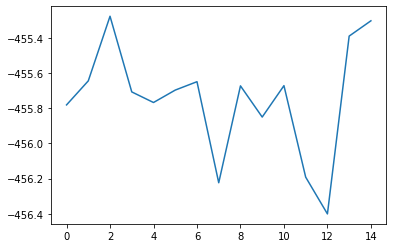

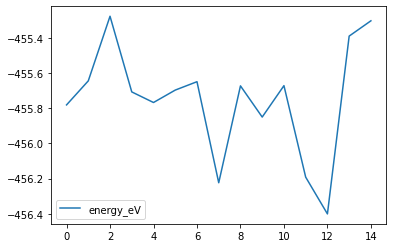

In [32]:
# test()